In [1]:
from cmb.configs.experiments import Configs
from cmb.datasets.jetclass import JetsBoundaryData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic_hybrid.yaml')
jets = JetsBoundaryData(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config)


2024-09-25 18:22:04.796582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 18:22:04.841840: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 18:22:04.842672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 18:22:05.579180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ValueError: computed checksum 330615436058665284 didn't match expected checksum 2237136171533889838
in file /home/df630/CMB/data/JetClass/TTBarLep_000.root

## JetClass data

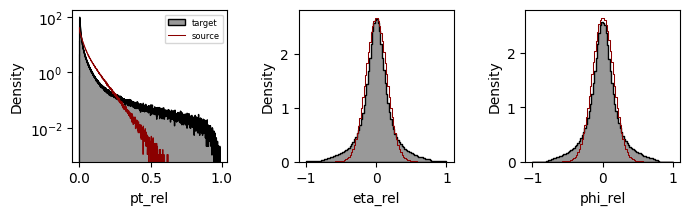

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

(None, None)

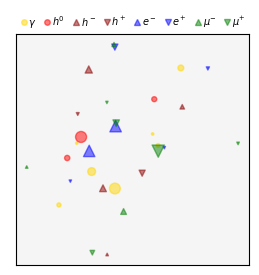

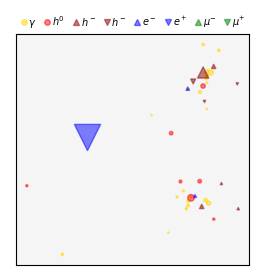

In [5]:
jets.source.display_cloud(idx=10,  scale_marker=200.0), jets.target.display_cloud(idx=20,  scale_marker=200.0)


In [65]:
jets.source.multiplicity.shape

torch.Size([100000])

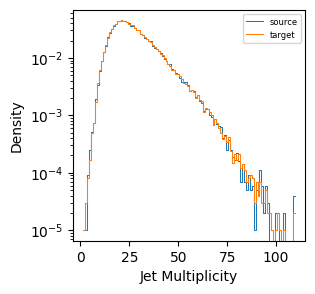

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [2]:
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.epic import HybridEPiC
from cmb.dynamics.cmb import ConditionalMarkovBridge

hepic = HybridEPiC(config)
dynamics = ConditionalMarkovBridge(config)
epic_cmb = CMBTrainer(config, dynamics, hepic, jets)

# epic_cmb.load(path='/home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalMarkovBridge_HybridEPiC_2024.09.25_11h49')
epic_cmb.train()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


In [3]:
import torch
from cmb.models.pipelines import Pipeline

num_gen_jets = 4000

pipeline = Pipeline(config=config, trained_model=epic_cmb, dynamics=dynamics)
test = JetsBoundaryData(config.data)

pipeline.generate_samples(source_continuous=test.source.continuous[:num_gen_jets], 
                          source_discrete=torch.tensor(test.source.discrete[:num_gen_jets]),
                          mask=test.source.mask[:num_gen_jets])


/tmp/ipykernel_2305104/3030936854.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_discrete=torch.tensor(test.source.discrete[:num_gen_jets]),


In [4]:
gen_discrete = pipeline.jumps[-1].unsqueeze(-1)
gen_continuous = pipeline.paths[-1]  
gen_discrete = gen_discrete.squeeze(-1)

gen_discrete.shape, jets.target.discrete.shape

(torch.Size([4000, 128]), torch.Size([100000, 128]))

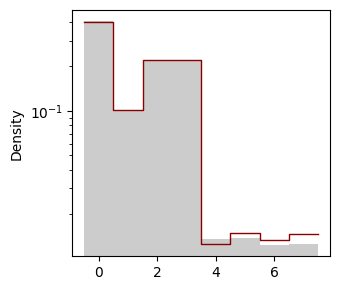

In [9]:
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))

mask_gen = test.source.mask[:num_gen_jets] > 0
mask_data = jets.target.mask > 0

sns.histplot(jets.target.discrete[mask_data.squeeze(-1)], discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))
sns.histplot(gen_discrete[mask_gen.squeeze(-1)], discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()

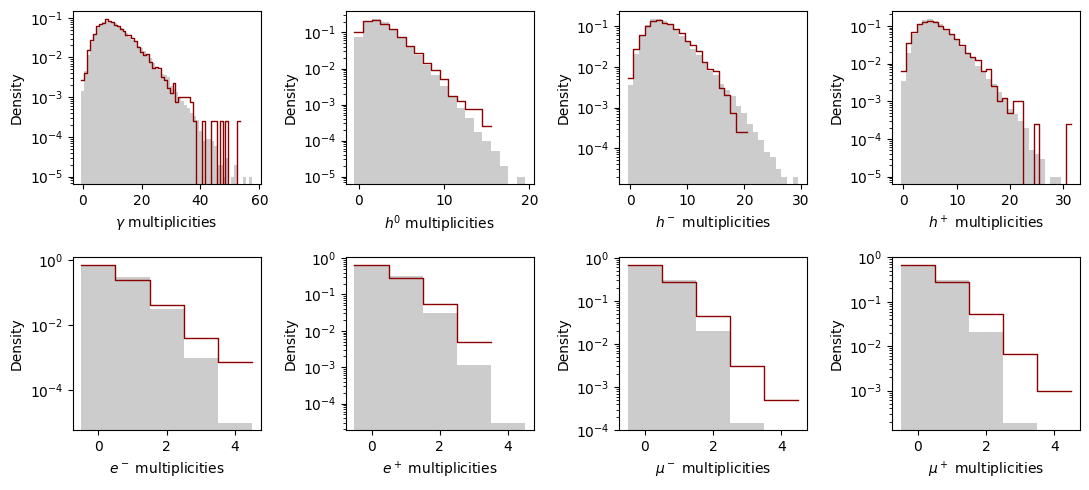

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(11,5))

dic = {0:r'$\gamma$', 1:r'$h^0$', 2:r'$h^-$', 3:r'$h^+$', 4:r'$e^-$', 5:r'$e^+$', 6:r'$\mu^-$', 7:r'$\mu^+$'}

for n in [0,1,2,3]:
    gen_counts = (gen_discrete == n) * mask_gen.squeeze(-1) 
    gen_counts = gen_counts.sum(dim=1)
    data_counts = (jets.target.discrete== n) * mask_data.squeeze(-1)
    data_counts = data_counts.sum(dim=1)
    
    sns.histplot(data_counts , discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True), ax=ax[0,n])
    sns.histplot(gen_counts, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True), ax=ax[0,n])
    ax[0,n].set_xlabel(f'{dic[n]} multiplicities')
for n in [0,1,2,3]:
    gen_counts = (gen_discrete == 4+n).sum(dim=1)
    data_counts = (jets.target.discrete== 4+n).sum(dim=1)
    sns.histplot(data_counts , discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True), ax=ax[1,n])
    sns.histplot(gen_counts, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True), ax=ax[1,n])
    ax[1,n].set_xlabel(f'{dic[4+n]} multiplicities')

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()



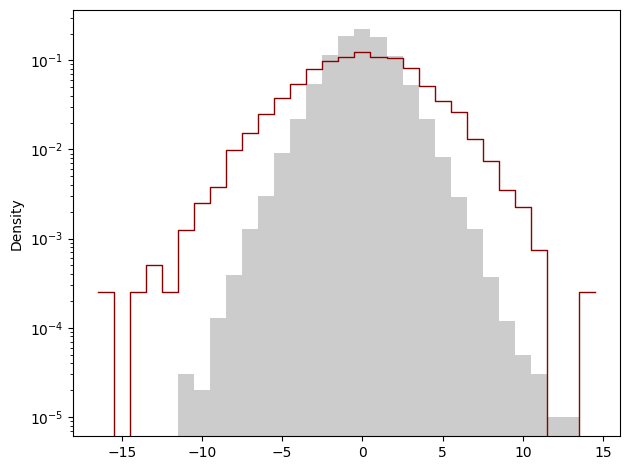

In [32]:
gen_total_charge = (gen_discrete == 2).sum(dim=1) - (gen_discrete == 3).sum(dim=1) + (gen_discrete == 4).sum(dim=1) - (gen_discrete == 5).sum(dim=1) + (gen_discrete == 6).sum(dim=1) - (gen_discrete == 7).sum(dim=1)
data_total_charge = (jets.target.discrete == 2).sum(dim=1) - (jets.target.discrete == 3).sum(dim=1) + (jets.target.discrete == 4).sum(dim=1) - (jets.target.discrete == 5).sum(dim=1) + (jets.target.discrete == 6).sum(dim=1) - (jets.target.discrete == 7).sum(dim=1)

sns.histplot(gen_total_charge, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
sns.histplot(data_total_charge, discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_charge.png')
plt.show()



In [ ]:
gen_total_charge = (gen_discrete == 2).sum(dim=1) - (gen_discrete == 3).sum(dim=1) + (gen_discrete == 4).sum(dim=1) - (gen_discrete == 5).sum(dim=1) + (gen_discrete == 6).sum(dim=1) - (gen_discrete == 7).sum(dim=1)
data_total_charge = (jets.target.discrete == 2).sum(dim=1) - (jets.target.discrete == 3).sum(dim=1) + (jets.target.discrete == 4).sum(dim=1) - (jets.target.discrete == 5).sum(dim=1) + (jets.target.discrete == 6).sum(dim=1) - (jets.target.discrete == 7).sum(dim=1)

sns.histplot(gen_total_charge, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
sns.histplot(data_total_charge, discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_charge.png')
plt.show()

jumps = pipeline.jumps[-1].unsqueeze(-1) * test.source.mask[:num_gen_jets]

jumps[0]

varying number of constituents (max. 128)

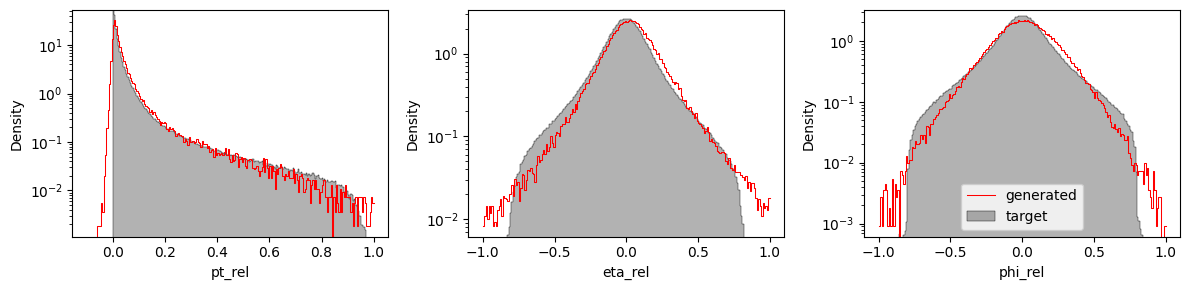

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', binrange=(-1, 1), binwidth=0.01, ax=ax[2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_distributions.png')
plt.show()

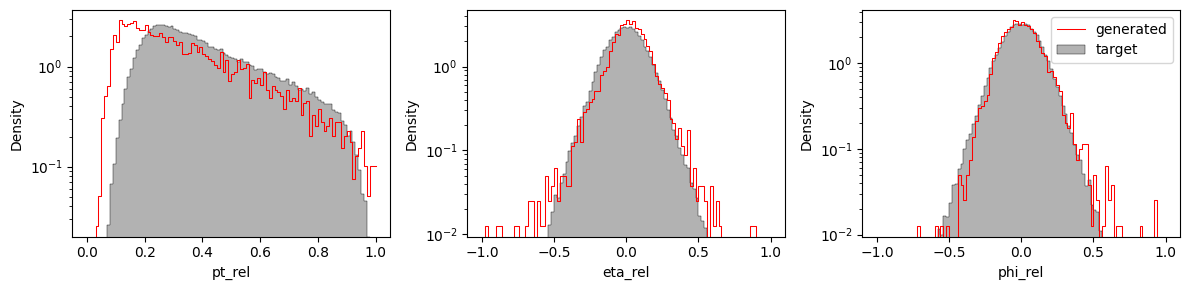

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', idx=0, binrange=(0, 1), binwidth=0.01, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=0, binrange=(0, 1), binwidth=0.01, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=0, binrange=(-1, 1), binwidth=0.02, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=0,  binrange=(-1, 1), binwidth=0.02, ax=ax[1],  log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=0, binrange=(-1, 1), binwidth=0.02, ax=ax[2],log_scale=(False, True),  color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=0, binrange=(-1, 1), binwidth=0.02, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

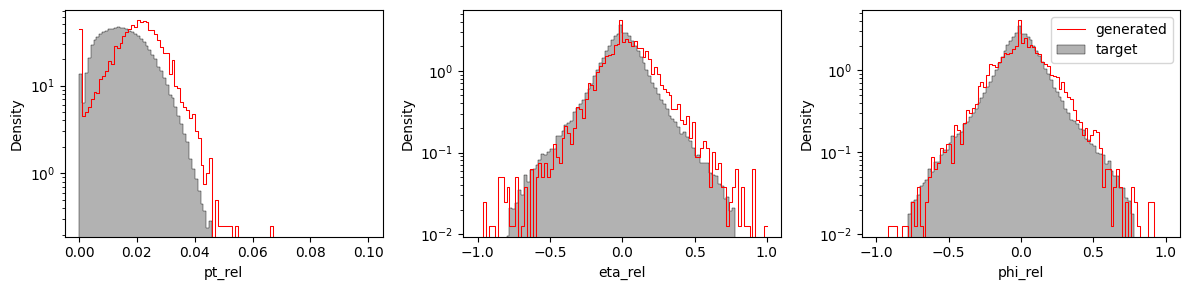

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

jets_generated.histplot('pt_rel', idx=10, binrange=(0, .1), binwidth=0.001, ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=10, binrange=(0, .1), binwidth=0.001, ax=ax[0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=10,  binrange=(-1, 1), binwidth=0.02, ax=ax[1],  log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],log_scale=(False, True),  color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, ax=ax[2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()